<a href="https://colab.research.google.com/github/pbenito1/TFM/blob/main/MachineLearning_Ngrams.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
# Imports
import re
import os
from collections import Counter
import pandas as pd
from math import log
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn import ensemble
from sklearn import feature_extraction
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,accuracy_score, recall_score, confusion_matrix,plot_confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

# Clasificadores

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn import tree

%matplotlib inline

In [2]:
def custom_cm(cf_matrix):
  # Ref: https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
  group_names = ['TN','FP','FN','TP']
  group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

## N-Grams

En este experimento utilizaremos las características basadas en N-gramas. 

En concreto, obtendremos los 3-gramas, 4-gramas, 5-gramas y 6-gramas del TLD de los dominios benignos del *dataset* obtenidos en la fase de _feature engineering_. Para la obtención de n-grams se utilizó la clase `CountVectorizer` de la librería `sklearn`, proporcionándole los parámetros `analyzer='char'` (de lo contrario asumiría que se quiere realizar la división a nivel de palabra) y  `ngram_range=(x, x)`, donde `x` es el número de elementos del n-gramas. 





In [3]:
DATASET_PATH='/content/drive/MyDrive/TFM/data_processed/dga.csv'
df = pd.read_csv(DATASET_PATH,index_col=0)

In [4]:
df.shape

(1142536, 15)

In [6]:
df.sample(4)

,domain,family,category,tld,sld,subdomains_number,digits,length,num_dashes,entropy,ratio_vc,3gram,4gram,5gram,6gram
600692,leisu.com,benign,benign,com,leisu,2,0,5,0,2.321928,1.500000,3,2,1,0
1034550,stickermobi.com,benign,benign,com,stickermobi,2,0,11,0,3.277613,0.571429,9,8,7,6
1120555,eternallysunny.com,benign,benign,com,eternallysunny,2,0,14,0,3.039149,0.400000,12,11,10,9
594646,yonobusiness.sbi,benign,benign,sbi,yonobusiness,2,0,12,0,2.855389,0.714286,10,9,8,7


Eliminamos las variables tipo texto, categóricas y los características léxicas

In [7]:
y = df['category']
X = df.drop(['family','category','domain','tld','sld','subdomains_number','digits','length','entropy','ratio_vc'], axis=1)

Aplicamos a las variables restantes un escalado estandar, en el cual a cada columna se le resta la media de esa columna y se le divide por su desviación típica. Utilizamos para ello la función `StandarScaler` de la librería `sklearn`:

In [11]:
X_std_scaler = StandardScaler().fit_transform(X)
X_std = pd.DataFrame(X_std_scaler, index=X.index, columns=X.columns)

Realizamos un muestreo estratificado en función de la familia.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df['family'])
X_train_std, X_test_std, y_train_std, y_test_std = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df['family'])

#Regresión logística

En primer lugar vamos a entrenar un clasificador clásico basado en regresión logística. Para el entrenamiento utilizaremos los datos previamente estandarizados.

In [14]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
log_clf.fit(X_train_std, y_train_std)
y_pred_rf = log_clf.predict(X_test_std)

In [15]:
print("El accuracy del clasificador LogisticRegression con n-grams es:", log_clf.score(X_test_std, y_test_std))

El accuracy del clasificador LogisticRegression con n-grams es: 0.9654541635303797


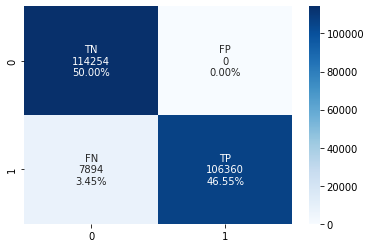

In [16]:
cf_matrix = confusion_matrix(y_test_std, y_pred_rf)
custom_cm(cf_matrix)

In [17]:
print(classification_report(y_test_std, y_pred_rf))

              precision    recall  f1-score   support

      benign       0.94      1.00      0.97    114254
      malign       1.00      0.93      0.96    114254

    accuracy                           0.97    228508
   macro avg       0.97      0.97      0.97    228508
weighted avg       0.97      0.97      0.97    228508



Se observa que el clasificador obtenido se comporta de forma excelente, con un _accuracy_ de un 96,5%. 

En la matriz de confusión se observa que todos los casos clasificados erróneamente se corresponden con falsos negativos.

# Árbol de decision

Uno de los clasificadores más comunes y estudiados son los árboles de decisión. La ventaja que aporta este tipo de modelos no está relacionada con su capacidad de predicción, sino con su capacidad explicativa y la facilidad con la que se puede interpretar el modelo obtenido.

In [19]:
# Instanciamos DecisionTreeClassifier de sklearn
dt_cls = DecisionTreeClassifier(max_depth = 3,  # Máxima profundidad del árbol
                             random_state = 42) # Semilla pseudoaleatorios
# Entrenamos el modelo. Utilizamos los datos sin estandariza para facilitar la interpretación
dt_cls.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

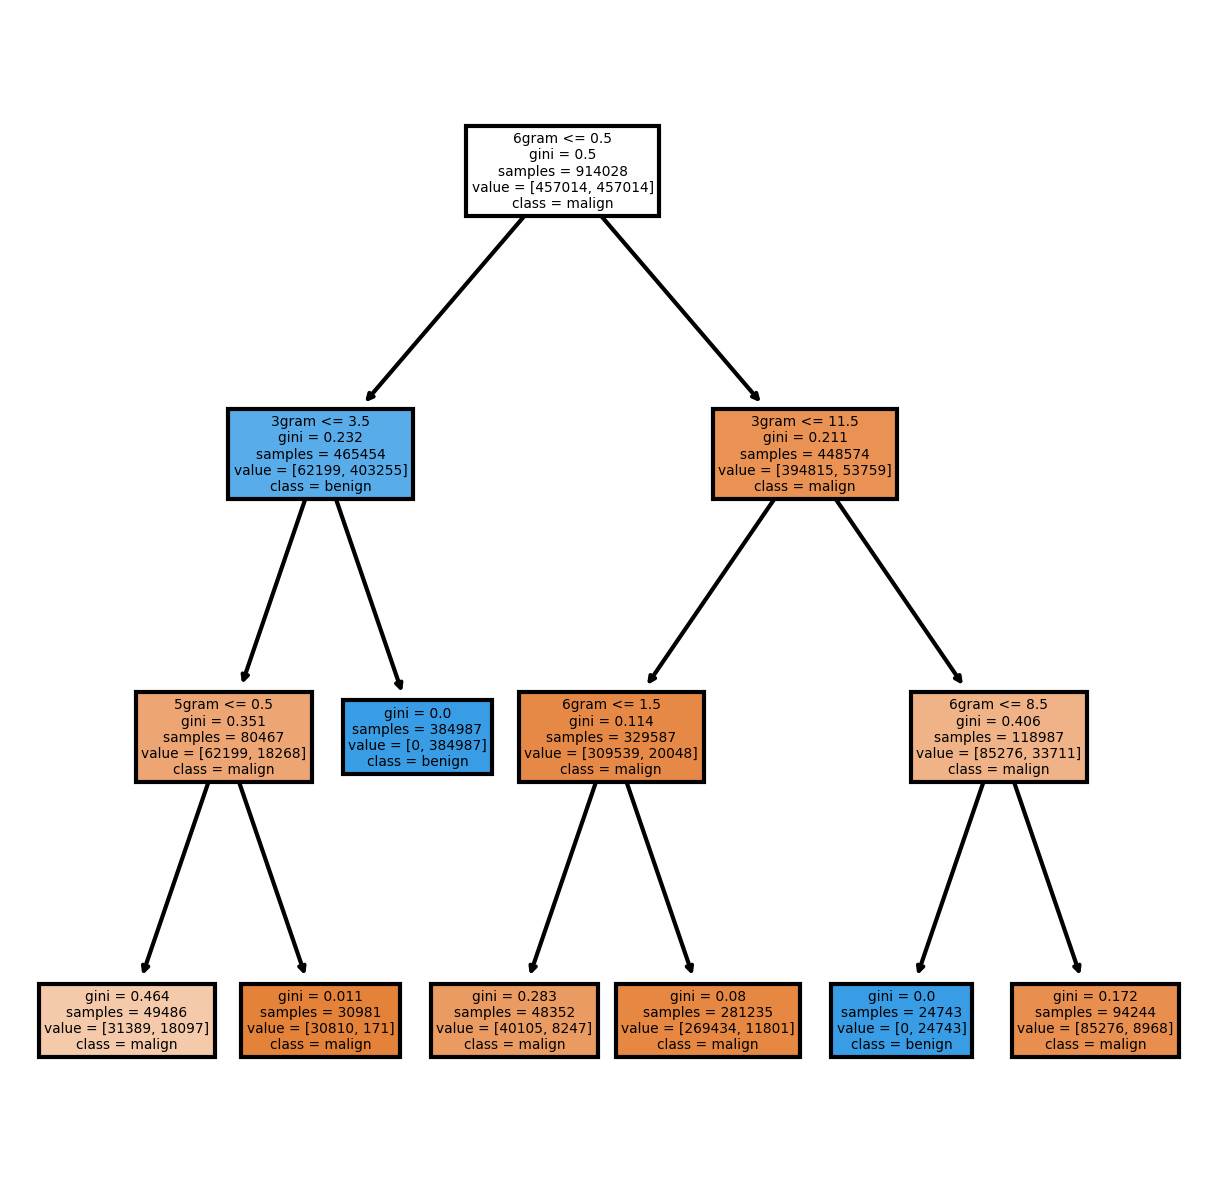

In [20]:
# Representamos el arbol
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (5,5), dpi=300)

tree.plot_tree(dt_cls,feature_names = X_train.columns, 
               class_names=['malign','benign'],
               filled = True,ax=axes);

In [21]:
y_test_pred = dt_cls.predict(X_test)
print("Accuracy para el conjunto de test:", sklearn.metrics.accuracy_score(y_test, y_test_pred))

Accuracy para el conjunto de test: 0.9483781749435468


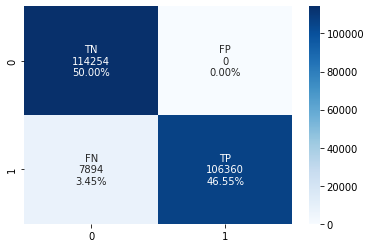

In [22]:
cf_matrix = confusion_matrix(y_test_std, y_pred_rf)
custom_cm(cf_matrix)

In [23]:
print(classification_report(y_test_std, y_pred_rf))

              precision    recall  f1-score   support

      benign       0.94      1.00      0.97    114254
      malign       1.00      0.93      0.96    114254

    accuracy                           0.97    228508
   macro avg       0.97      0.97      0.97    228508
weighted avg       0.97      0.97      0.97    228508



Dado que el algoritmo de clasificación `Decision Tree` facilita la interpretación visual, para entrenar el clasificador se han utilizado los datos sin estandarizar y se ha limitado la profundidad del árbol a 3 niveles.

El entrenamiento del clasificador ofrece un `accuracy`de 0,94 sobre el conjunto de test. Se puede observar que las dos variables más significativas son el `6gram` y `3gram`, que se emplean en la clasificación en las partes superiores del árbol de decisión. De su lectura se puede determinar que el primer criterio de clasificación se basa en que en el caso de que `6gram` tenga un valor inferior a 0,5 (es decir, si tiene valor 0), se trata de una muestra maligna.

En la matriz de confusión llama la atención que todos los casos fallidos se corresponden con falsos negativos.

# Random Forest

Por último, entrenaremos un clasificador $random forest$, tipo $ensemble$ basado en múltiples árboles de decisión.

Esta combinación de clasificadores realiza un muestreo tanto de elementos del dataset original de entrenamiento como de sus variables, a partir de ese muestreo aleatorio se crean múltiples árboles.

In [24]:
rf = RandomForestClassifier()
rf.fit(X_train_std, y_train_std)
y_pred_rf = rf.predict(X_test_std)

In [25]:
print("El accuracy del modelo Random Forest es:",rf.score(X_test_std, y_test_std))

El accuracy del modelo Random Forest es: 0.9803070352022686


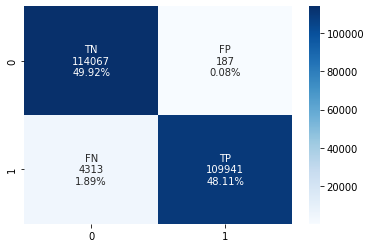

In [26]:
cf_matrix = confusion_matrix(y_test_std, y_pred_rf)
custom_cm(cf_matrix)

In [27]:
print(classification_report(y_test_std, y_pred_rf))

              precision    recall  f1-score   support

      benign       0.96      1.00      0.98    114254
      malign       1.00      0.96      0.98    114254

    accuracy                           0.98    228508
   macro avg       0.98      0.98      0.98    228508
weighted avg       0.98      0.98      0.98    228508



Como era de esperar, este clasificador obtiene los mejores resultados, con un _accuracy_ sobre el conjunto de test de 98%. 

En la matriz de confusión se observa que el porcentaje de falsos negativos es bastante reducido (1,89%) y el de falsos positivos prácticamente nulo(0,1%)

# Conclusiones

Los modelos entrenados a partir de n-gramas han resultado mucho más precisos que los obtenidos a partir de los atributos léxicos. 

De todos los modelos entrenados, el que mejores resultados arroja es el _Random forest_ con un 98% de Accuracy. Los otros clasificadores ofrecen igualmente excelentes resultados.


Además de la alternativa propuesta, otras posibilidades de análisis basado en n-gramas podrían haber sido sido:

- Utilizar "*masked n-grams*", como el propuesto en el artículo ["Detection of algorithmically generated malicious domain names using masked N-grams"](https://zaguan.unizar.es/record/87544/files/texto_completo.pdf). En este caso, los dominios son previamente tratados, mapeandose todas las vocales al carácter "v", las consonantes al caracter "c", los dígitos al caracter "n" y el resto de símbolos al caracter "s". Por ejemplo el dominio "google" se convertiría en a "cvvccv".

- Realizar la extracción de n-grams a partir de un diccionario de las palabras más comunes en inglés, como lo propuesto en el proyecto europeo [SOCCRATES](https://www.soccrates.eu/wp-content/uploads/2022/05/SOCCRATES_D4.3-Threat-Identification-and-Threat-Trend-prediction-%E2%80%93-Final-Prototype-Final.pdf), en la que combinan el núero de n-gramas con otras características como la longitud del dominio, ...

Asimismo y como en el caso de los atributos léxicos, se podría haber utilizado una librería de AutoML como `auto-sklearn`, que combinaría los mejores clasificadores, pero se considera que los modelos evaluados son suficientes para mostrar una representación de las distintas alternativas disponibles y sus características, y a su vez reducir el consumo eléctrico requerido para el entrenamiento de estos modelos.